Total records across all projects: 11428
Accuracy: 0.91
Accuracy: 0.98


/tmp/ipykernel_95253/3838496542.py:178: UserWarning: The palette list has more values (33) than needed (32), which may not be intended.
  sns.scatterplot(


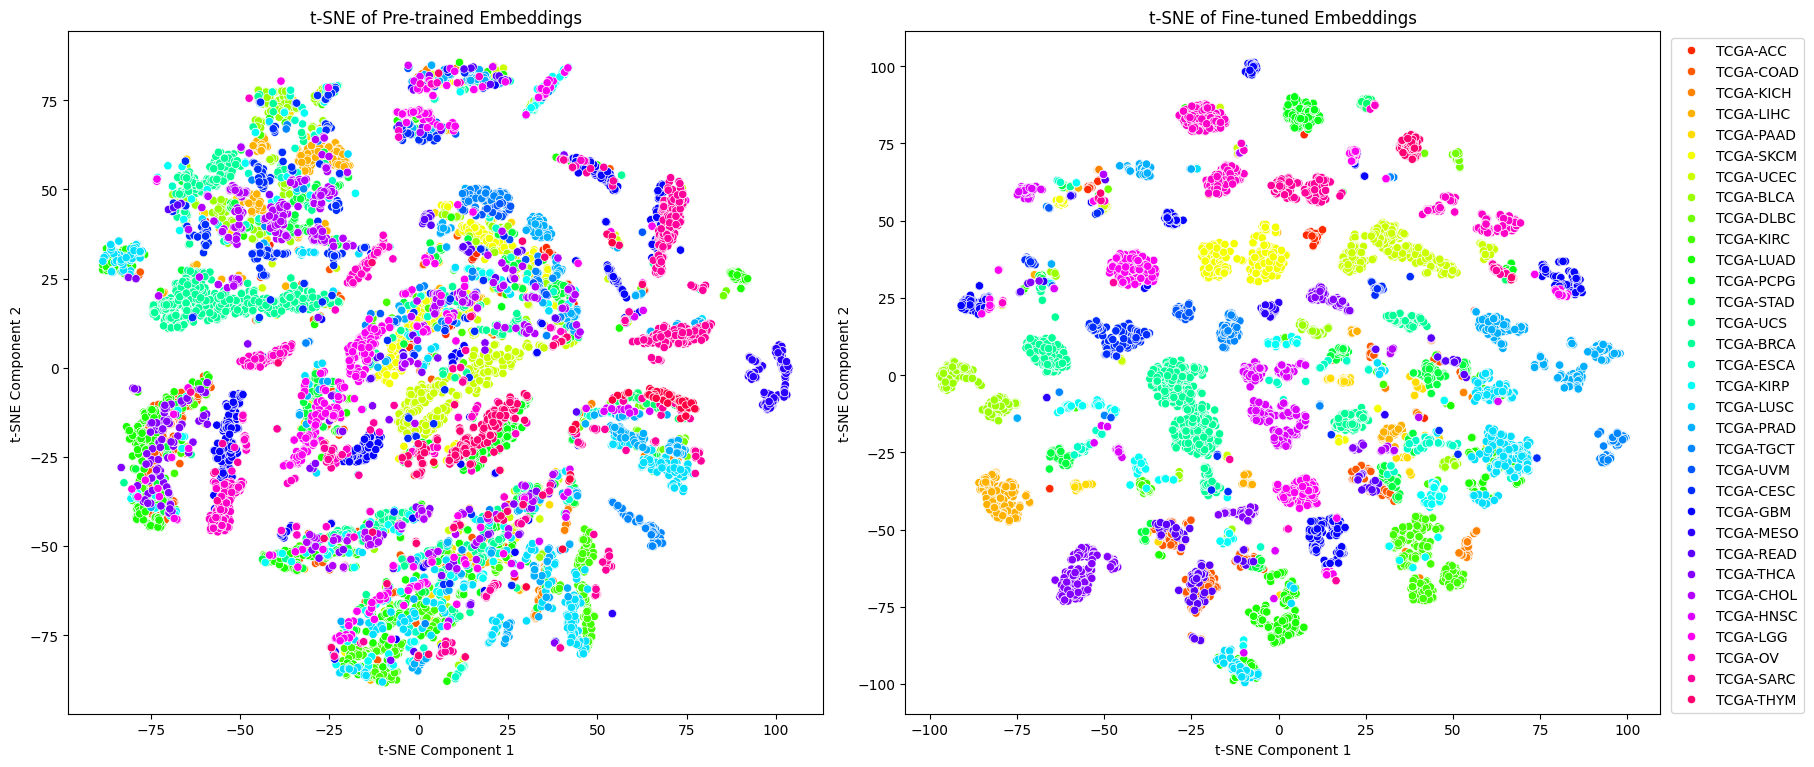

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

ALL_DATA_PATH = "all_data_with_embeddings.parquet"
EMBEDDINGS_SAVE_PATH = "ft_all_data_with_embeddings.parquet"
PRE_TRAINED_MODEL = "UFNLP/gatortron-base"
FINE_TUNED_MODEL = "./gatortron-base-tcga"

PROJECTS = [
    "TCGA-ACC",
    "TCGA-COAD",
    "TCGA-KICH",
    "TCGA-LIHC",
    "TCGA-PAAD",
    "TCGA-SKCM",
    "TCGA-UCEC",
    "TCGA-BLCA",
    "TCGA-DLBC",
    "TCGA-KIRC",
    "TCGA-LUAD",
    "TCGA-PCPG",
    "TCGA-STAD",
    "TCGA-UCS",
    "TCGA-BRCA",
    "TCGA-ESCA",
    "TCGA-KIRP",
    "TCGA-LUSC",
    "TCGA-PRAD",
    "TCGA-TGCT",
    "TCGA-UVM",
    "TCGA-CESC",
    "TCGA-GBM",
    "TCGA-LAML",
    "TCGA-MESO",
    "TCGA-READ",
    "TCGA-THCA",
    "TCGA-CHOL",
    "TCGA-HNSC",
    "TCGA-LGG",
    "TCGA-OV",
    "TCGA-SARC",
    "TCGA-THYM",
]

all_data = pd.DataFrame()
for PROJECT in PROJECTS:
    try:
        clinical_dataset = load_dataset(
            "parquet",
            data_files=f"/mnt/d/TCGA/parquet/{PROJECT}/Clinical Data.parquet",
            split="train",
        )
        all_data = pd.concat(
            [all_data, clinical_dataset.to_pandas()], ignore_index=True
        )
    except FileNotFoundError:
        print(f"{PROJECT}: Data not found")
print("Total records across all projects:", len(all_data))
all_data.to_parquet(ALL_DATA_PATH)


# ------------------- Train a classifier on the embeddings -------------------
X = np.array([np.frombuffer(e, dtype=np.float32) for e in all_data["embedding"]])
y = all_data["project_id"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
# Predict on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# ------------------- Visualize the embeddings -------------------
# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)
unique_projects = np.unique(y)
palette = sns.color_palette("hsv", len(unique_projects))
project_to_color = {project: palette[i] for i, project in enumerate(unique_projects)}
colors = [project_to_color[project] for project in y]

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, legend=None, palette=palette
)
plt.title("t-SNE of Pre-trained Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# ------------------- Generate or Load embeddings -------------------
if not os.path.exists(EMBEDDINGS_SAVE_PATH):
    all_data = pd.read_parquet(ALL_DATA_PATH)
    dataset = Dataset.from_pandas(all_data)
    # Load the model and tokenizer
    model = AutoModel.from_pretrained(FINE_TUNED_MODEL)
    tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    model.eval()
    model.to(device)

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"], padding="max_length", truncation=True, max_length=512
        )

    # Apply tokenization
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

    # Create DataLoader
    dataloader = DataLoader(tokenized_dataset, batch_size=16)

    # Generate embeddings
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Embeddings"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            # Extract the embeddings from the last hidden state and take the mean across the sequence length
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)

    # Convert embeddings to a format suitable for DataFrame
    all_data["embeddings"] = list(
        map(list, embeddings)
    )  # Convert each numpy array to a list

    # Save the DataFrame with embeddings to a Parquet file
    all_data.to_parquet(EMBEDDINGS_SAVE_PATH)
else:
    # Load the DataFrame with embeddings from the Parquet file
    all_data = pd.read_parquet(EMBEDDINGS_SAVE_PATH)
    X = np.array([np.frombuffer(e, dtype=np.float32) for e in all_data["embeddings"]])
    y = all_data["project_id"].values

# ------------------- Train a classifier on the embeddings -------------------
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
# Predict on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# ------------------- Visualize the embeddings -------------------
# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced_ft = tsne.fit_transform(X)
# Prepare a color palette for the different project IDs
colors_ft = [project_to_color[project] for project in y]

plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_reduced_ft[:, 0], y=X_reduced_ft[:, 1], hue=y, legend="full", palette=palette
)
plt.title("t-SNE of Fine-tuned Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()
plt.show()

In [ ]:
# # fine-tune the gatortron-base model on the TCGA dataset
# from transformers import (
#     AutoTokenizer,
#     TrainingArguments,
#     Trainer,
#     AutoModelForSequenceClassification,
# )
# from datasets import Dataset
# import pandas as pd
# import numpy as np
# from sklearn.metrics import (
#     accuracy_score,
#     precision_recall_fscore_support,
#     classification_report,
# )
# from transformers import BitsAndBytesConfig
# from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
# import torch


# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(
#         labels, predictions, average="weighted"
#     )
#     acc = accuracy_score(labels, predictions)
#     return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


# def prepare_data_and_tokenize(all_data, tokenizer):
#     # Ensure 'project_id' is used as a label and it is in an appropriate format
#     unique_labels = all_data["project_id"].unique().tolist()
#     label_dict = {label: i for i, label in enumerate(unique_labels)}
#     all_data["labels"] = all_data["project_id"].map(label_dict)

#     # Convert DataFrame to a Dataset object
#     dataset = Dataset.from_pandas(all_data[["text", "labels"]])

#     # Tokenization function to prepare input data
#     def tokenize_function(examples):
#         model_inputs = tokenizer(
#             examples["text"], padding="max_length", truncation=True, max_length=512
#         )
#         model_inputs["labels"] = examples[
#             "labels"
#         ]  # Ensure labels are included for the model to compute loss
#         return model_inputs

#     # Apply tokenization
#     tokenized_datasets = dataset.map(tokenize_function, batched=True)

#     # Split the dataset
#     tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)
#     return tokenized_datasets["train"], tokenized_datasets["test"]


# unique_labels = all_data["project_id"].unique().tolist()

# # Load tokenizer and model
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)
# tokenizer = AutoTokenizer.from_pretrained("UFNLP/gatortron-base")
# model = AutoModelForSequenceClassification.from_pretrained(
#     "UFNLP/gatortron-base",
#     num_labels=len(unique_labels),
#     torch_dtype=torch.float16,
#     quantization_config=quantization_config,
# )
# config = LoraConfig(
#     r=4,
#     lora_alpha=16,
#     lora_dropout=0.1,
#     target_modules=["key", "query", "value"],
#     bias="none",
#     task_type="CAUSAL_LM",
# )
# lora_model = get_peft_model(model, config)

# # Prepare and tokenize data
# train_dataset, test_dataset = prepare_data_and_tokenize(all_data, tokenizer)

# # Updated training arguments
# training_args = TrainingArguments(
#     output_dir="./results",  # Store all outputs and model checkpoints here.
#     evaluation_strategy="epoch",  # Evaluation is done at the end of each epoch.
#     save_strategy="epoch",  # Save checkpoints at the end of each epoch to align with evaluations.
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=16,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     logging_dir="./logs",  # Directory for storing logs
#     logging_steps=10,  # Log training info every 10 steps.
#     load_best_model_at_end=True,  # Load the best model found during training at the end.
#     metric_for_best_model="accuracy",  # Use accuracy to determine the best model.
#     fp16=True,  # Use mixed precision training.
# )


# # Initialize the Trainer
# trainer = Trainer(
#     model=lora_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,  # Function to compute metrics during evaluation
# )

# # Train the model
# train_result = trainer.train()

# # Print training results
# print("Training completed. Here are the stats:")
# print(train_result)

# # Evaluate the model
# predictions = trainer.predict(test_dataset)
# y_pred = np.argmax(predictions.predictions, axis=-1)
# print(classification_report(test_dataset["labels"], y_pred))

# MODEL_SAVE_FOLDER_NAME = "gatortron-base-tcga"
# trainer.model.save_pretrained(MODEL_SAVE_FOLDER_NAME)
# trainer.save_model(MODEL_SAVE_FOLDER_NAME)
# trainer.model.config.save_pretrained(MODEL_SAVE_FOLDER_NAME)

---

Accuracy: 0.78
Accuracy: 0.90


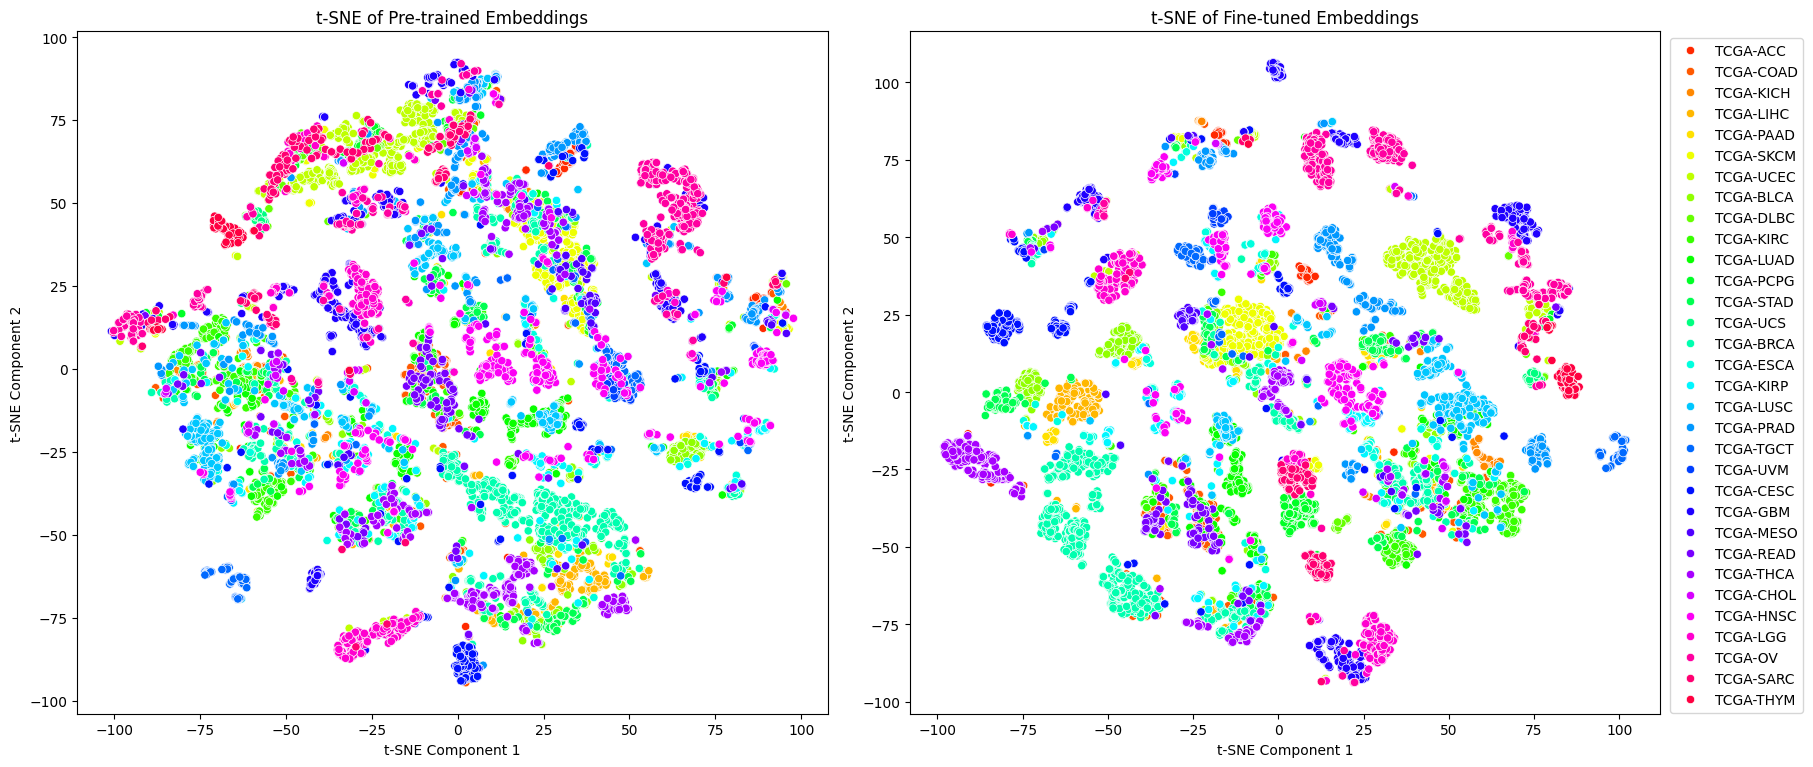

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

ALL_DATA_PATH = "bert_all_data_with_embeddings.parquet"
EMBEDDINGS_SAVE_PATH = "ft_bert_all_data_with_embeddings.parquet"
PRE_TRAINED_MODEL = "bert-base-uncased"
FINE_TUNED_MODEL = "./bert-base-uncased-tcga"

# ------------------- Train a classifier on the embeddings -------------------
all_data = pd.read_parquet(ALL_DATA_PATH)
X = np.array([np.frombuffer(e, dtype=np.float32) for e in all_data["embedding"]])
y = all_data["project_id"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
# Predict on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# ------------------- Visualize the embeddings -------------------
# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)
unique_projects = np.unique(y)
palette = sns.color_palette("hsv", len(unique_projects))
project_to_color = {project: palette[i] for i, project in enumerate(unique_projects)}
colors = [project_to_color[project] for project in y]
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, legend=None, palette=palette
)
plt.title("t-SNE of Pre-trained Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# ------------------- Generate or Load embeddings -------------------
if not os.path.exists(EMBEDDINGS_SAVE_PATH):
    all_data = pd.read_parquet(ALL_DATA_PATH)
    dataset = Dataset.from_pandas(all_data)
    # Load the model and tokenizer
    model = AutoModel.from_pretrained(FINE_TUNED_MODEL)
    tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    model.eval()
    model.to(device)

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"], padding="max_length", truncation=True, max_length=512
        )

    # Apply tokenization
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

    # Create DataLoader
    dataloader = DataLoader(tokenized_dataset, batch_size=16)

    # Generate embeddings
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Embeddings"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            # Extract the embeddings from the last hidden state and take the mean across the sequence length
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)

    # Convert embeddings to a format suitable for DataFrame
    all_data["embeddings"] = list(
        map(list, embeddings)
    )  # Convert each numpy array to a list

    # Save the DataFrame with embeddings to a Parquet file
    all_data.to_parquet(EMBEDDINGS_SAVE_PATH)
else:
    # Load the DataFrame with embeddings from the Parquet file
    all_data = pd.read_parquet(EMBEDDINGS_SAVE_PATH)
    X = np.array([np.frombuffer(e, dtype=np.float32) for e in all_data["embeddings"]])
    y = all_data["project_id"].values

# ------------------- Train a classifier on the embeddings -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# ------------------- Visualize the embeddings -------------------
tsne = TSNE(n_components=2, random_state=42)
X_reduced_ft = tsne.fit_transform(X)
colors_ft = [project_to_color[project] for project in y]
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_reduced_ft[:, 0], y=X_reduced_ft[:, 1], hue=y, legend="full", palette=palette
)
plt.title("t-SNE of Fine-tuned Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()
plt.show()

In [ ]:
# # fine-tune the bert-base-uncased model on the TCGA dataset
# from transformers import (
#     AutoTokenizer,
#     TrainingArguments,
#     Trainer,
#     AutoModelForSequenceClassification,
# )
# from datasets import Dataset
# import pandas as pd
# import numpy as np
# from sklearn.metrics import (
#     accuracy_score,
#     precision_recall_fscore_support,
#     classification_report,
# )
# from transformers import BitsAndBytesConfig
# from peft import LoraConfig, get_peft_model
# import torch


# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(
#         labels, predictions, average="weighted"
#     )
#     acc = accuracy_score(labels, predictions)
#     return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


# def prepare_data_and_tokenize(all_data, tokenizer):
#     # Ensure 'project_id' is used as a label and it is in an appropriate format
#     unique_labels = all_data["project_id"].unique().tolist()
#     label_dict = {label: i for i, label in enumerate(unique_labels)}
#     all_data["labels"] = all_data["project_id"].map(label_dict)

#     # Convert DataFrame to a Dataset object
#     dataset = Dataset.from_pandas(all_data[["text", "labels"]])

#     # Tokenization function to prepare input data
#     def tokenize_function(examples):
#         model_inputs = tokenizer(
#             examples["text"], padding="max_length", truncation=True, max_length=512
#         )
#         model_inputs["labels"] = examples[
#             "labels"
#         ]  # Ensure labels are included for the model to compute loss
#         return model_inputs

#     # Apply tokenization
#     tokenized_datasets = dataset.map(tokenize_function, batched=True)

#     # Split the dataset
#     tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)
#     return tokenized_datasets["train"], tokenized_datasets["test"]


# unique_labels = all_data["project_id"].unique().tolist()

# # Load tokenizer and model
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased",
#     num_labels=len(unique_labels),
#     torch_dtype=torch.float16,
#     quantization_config=quantization_config,
# )
# config = LoraConfig(
#     r=4,
#     lora_alpha=16,
#     lora_dropout=0.1,
#     target_modules=["key", "query", "value"],
#     bias="none",
#     task_type="CAUSAL_LM",
# )
# lora_model = get_peft_model(model, config)

# # Prepare and tokenize data
# train_dataset, test_dataset = prepare_data_and_tokenize(all_data, tokenizer)

# # Updated training arguments
# training_args = TrainingArguments(
#     output_dir="./results",  # Store all outputs and model checkpoints here.
#     evaluation_strategy="epoch",  # Evaluation is done at the end of each epoch.
#     save_strategy="epoch",  # Save checkpoints at the end of each epoch to align with evaluations.
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=16,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     logging_dir="./logs",  # Directory for storing logs
#     logging_steps=10,  # Log training info every 10 steps.
#     load_best_model_at_end=True,  # Load the best model found during training at the end.
#     metric_for_best_model="accuracy",  # Use accuracy to determine the best model.
#     fp16=True,  # Use mixed precision training.
# )


# # Initialize the Trainer
# trainer = Trainer(
#     model=lora_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,  # Function to compute metrics during evaluation
# )

# # Train the model
# train_result = trainer.train()

# # Print training results
# print("Training completed. Here are the stats:")
# print(train_result)

# # Evaluate the model
# predictions = trainer.predict(test_dataset)
# y_pred = np.argmax(predictions.predictions, axis=-1)
# print(classification_report(test_dataset["labels"], y_pred))

# MODEL_SAVE_FOLDER_NAME = "bert-base-uncased-tcga"
# trainer.model.save_pretrained(MODEL_SAVE_FOLDER_NAME)
# trainer.save_model(MODEL_SAVE_FOLDER_NAME)
# trainer.model.config.save_pretrained(MODEL_SAVE_FOLDER_NAME)